<a href="https://colab.research.google.com/github/likeshd/time_series_models_libraries/blob/main/Multivariate_TS_Forecasting_conventional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-step Time Series Forecasting with Machine Learning
Machine learning algorithms predict a single value and cannot be used directly for multi-step forecasting. We can use recursive method to predict multiple point at a time

As we are aware the dataset consists of electricity consumption of individual household from 2006 to 2010

It is a multivariate series comprised of nine variables; they are:

date and time: From 2006 to 2010

global_active_power: The total active power consumed by the household (kilowatts). This is what we want to predict

global_reactive_power: The total reactive power consumed by the household (kilowatts).

In general terms, the active energy is the real power consumed by the household, whereas the reactive energy is the unused power in the lines.

voltage: Average voltage (volts).

global_intensity: Average current intensity (amps).

sub_metering_1: Active energy for kitchen (watt-hours of active energy).

sub_metering_2: Active energy for laundry (watt-hours of active energy).

sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

We can see that the dataset provides the active power as well as some division of the active power by main circuit in the house, specifically the kitchen, laundry, and climate control. These are not all the circuits in the household.

The remaining watt-hours can be calculated from the active energy by first converting the active energy to watt-hours then subtracting the other sub-metered active energy in watt-hours, as follows

sub_metering_4 = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)

In [3]:
# recursive multi-step forecast with linear algorithms
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

Lets Prepare the data
Let's load the data and handle the missing values

In [2]:
# load and clean-up data
from numpy import nan
from numpy import isnan
import pandas as pd
from pandas import read_csv
from pandas import to_numeric

In [12]:
# load all data
dataset = pd.read_csv("/content/household_power_consumption_days.csv", parse_dates= True, index_col= ["datetime"])
dataset.sort_index(inplace=True)

# sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
dataset.info()
# mark all missing values
# dataset.replace('?', nan, inplace=True)
# make dataset numeric
# dataset = dataset.astype('float32')
dataset.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    1442 non-null   float64
 1   Global_reactive_power  1442 non-null   float64
 2   Voltage                1442 non-null   float64
 3   Global_intensity       1442 non-null   float64
 4   Sub_metering_1         1442 non-null   float64
 5   Sub_metering_2         1442 non-null   float64
 6   Sub_metering_3         1442 non-null   float64
 7   sub_metering_4         1442 non-null   float64
dtypes: float64(8)
memory usage: 101.4 KB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


Fill missing values with a value at the same time one day ago

In [ ]:
# def fill_missing(values):
# 	one_day = 60 * 24
# 	for row in range(values.shape[0]):
# 		for col in range(values.shape[1]):
# 			if isnan(values[row, col]):
# 				values[row, col] = values[row - one_day, col]

In [ ]:
# # fill missing
# fill_missing(dataset.values)
# # add a column for for the remainder of sub metering
# values = dataset.values
# dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# # save updated dataset
# dataset.to_csv('household_power_consumption.csv')

In [5]:
dataset.isnull().sum()

datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

Define function to split data into train and test

In [15]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [19]:
# split into train and test
train, test = split_dataset(dataset.values)
test.shape

(46, 7, 8)

Lets Define functions for model buliding and model evaluation

In [20]:
# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['lars'] = Lars()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	print('Defined %d models' % len(models))
	return models

In [21]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [22]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

Let's call the models and evaluate against the actuals

In [23]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

In [24]:
# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
	yhat_sequence = list()
	input_data = [x for x in input_x]
	for j in range(7):
		# prepare the input data
		X = array(input_data[-n_input:]).reshape(1, n_input)
		# make a one-step forecast
		yhat = model.predict(X)[0]
		# add to the result
		yhat_sequence.append(yhat)
		# add the prediction to the input
		input_data.append(yhat)
	return yhat_sequence

In [25]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series

In [26]:
# convert history into inputs and outputs
def to_supervised(history, n_input):
	# convert history to a univariate series
	data = to_series(history)
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(data)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		# ensure we have enough data for this instance
		if ix_end < len(data):
			X.append(data[ix_start:ix_end])
			y.append(data[ix_end])
		# move along one time step
		ix_start += 1
	return array(X), array(y)

In [27]:
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
	# prepare data
	train_x, train_y = to_supervised(history, n_input)
	# make pipeline
	pipeline = make_pipeline(model)
	# fit the model
	pipeline.fit(train_x, train_y)
	# predict the week, recursively
	yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
	return yhat_sequence

In [28]:
# evaluate a single model
def evaluate_model(model, train, test, n_input):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

Defined 10 models
lr: [388.388] 411.0, 389.1, 338.0, 370.8, 408.5, 308.3, 471.1
lasso: [386.838] 403.6, 388.9, 337.3, 371.1, 406.1, 307.6, 471.6
ridge: [387.659] 407.9, 388.6, 337.5, 371.2, 407.0, 307.7, 471.7
en: [469.337] 452.2, 451.9, 435.8, 485.7, 460.4, 405.8, 575.1
huber: [392.465] 412.1, 388.0, 337.9, 377.3, 405.6, 306.9, 492.5
lars: [388.388] 411.0, 389.1, 338.0, 370.8, 408.5, 308.3, 471.1
llars: [386.836] 403.6, 388.9, 337.3, 371.1, 406.1, 307.6, 471.6
pa: [402.079] 418.3, 391.0, 341.7, 386.5, 412.9, 319.3, 515.0
ranscac: [448.498] 508.5, 458.4, 364.5, 392.0, 449.3, 381.2, 552.9
sgd: [387.623] 406.6, 390.2, 336.8, 371.5, 407.5, 308.2, 470.8


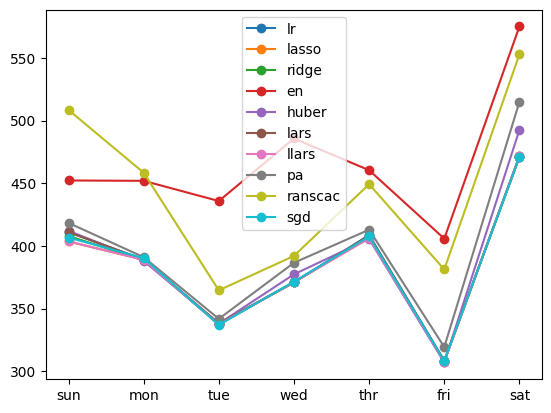

In [29]:
# prepare the models to evaluate
models = get_models()
n_input = 7
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, model in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(model, train, test, n_input)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()